# Setup

In [1]:
# imports
import pandas as pd
import seaborn as sns

In [2]:
# constants
RELEASED_VERSIONS = ["2.0.0", "2.0.1",
                     "2.1.0", "2.1.1", "2.2.0",
                     "2.3.0", "2.3.1", "2.3.2", "2.3.3", "2.3.4", "2.3.5", "2.3.6", "2.3.7", "2.3.8", "2.3.9",
                     "3.0.0", "3.1.0", "3.1.1", "3.1.2", "3.1.3"]

INPUT_DIR = "../../data/input/"
OUTPUT_DIR = "../../data/output/"

# Load data

We take a look at the raw metrics data to know how to process it 

In [3]:
df = pd.read_csv(INPUT_DIR + "hive-metrics-2.0.0.csv")
df.head()

,Kind,Name,AltAvgLineBlank,AltAvgLineCode,AltAvgLineComment,AltCountLineBlank,AltCountLineCode,AltCountLineComment,AvgCyclomatic,AvgCyclomaticModified,...,MaxInheritanceTree,MaxNesting,MinEssentialKnots,PercentLackOfCohesion,PercentLackOfCohesionModified,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
0,File,ACLConfigurationParser.java,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,...,NaN,3.0,NaN,NaN,NaN,0.16,29.0,29.0,32.0,22.0
1,File,AMReporter.java,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,3.0,NaN,NaN,NaN,0.13,65.0,65.0,68.0,36.0
2,File,ASTBuilder.java,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,...,NaN,2.0,NaN,NaN,NaN,0.09,90.0,32.0,90.0,22.0
3,File,ASTConverter.java,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,...,NaN,5.0,NaN,NaN,NaN,0.15,144.0,144.0,157.0,44.0
4,File,ASTErrorNode.java,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,0.0,NaN,NaN,NaN,0.95,5.0,5.0,5.0,5.0


We can see that we have metrics for not only files but also for packages, classes, and functions. Also, there are a lot more metrics than we want.
Therefore, we need to select precisely what we want from the dataset.

Below we can observe that classes' metrics don't have any value for files.

In [4]:
classes_metrics_cols = ["Name", "CountClassBase", "CountClassCoupled", "CountClassDerived", "MaxInheritanceTree", "PercentLackOfCohesion"]
df.loc[df["Kind"] == "File"][classes_metrics_cols].describe().loc["count"]

CountClassBase           0.0
CountClassCoupled        0.0
CountClassDerived        0.0
MaxInheritanceTree       0.0
PercentLackOfCohesion    0.0
Name: count, dtype: float64

Same for methods' metrics

In [5]:
methods_metrics_cols = ["Name", "CountInput", "CountClassCoupled", "CountClassDerived", "MaxInheritanceTree", "PercentLackOfCohesion"]
df.loc[df["Kind"] == "File"][methods_metrics_cols].describe().loc["count"]

CountInput               0.0
CountClassCoupled        0.0
CountClassDerived        0.0
MaxInheritanceTree       0.0
PercentLackOfCohesion    0.0
Name: count, dtype: float64

### Metrics selection

We therefore choose to only collect files' metrics as we are trying to predict bugs at files level.

In [6]:
metrics_cols = ["Name", "AvgCyclomatic", "AvgCyclomaticModified", "AvgCyclomaticStrict", "AvgEssential", "AvgLine", "AvgLineBlank", "AvgLineCode", 
    "AvgLineComment", "CountDeclClass", "CountDeclClassMethod", "CountDeclClassVariable", "CountDeclFunction", "CountDeclInstanceMethod",
    "CountDeclInstanceVariable", "CountDeclMethod", "CountDeclMethodDefault", "CountDeclMethodPrivate", "CountDeclMethodProtected",
    "CountDeclMethodPublic", "CountLine", "CountLineBlank", "CountLineCode", "CountLineCodeDecl", "CountLineCodeExe", "CountLineComment", 
    "CountSemicolon", "CountStmt", "CountStmtDecl", "CountStmtExe", "MaxCyclomatic", "MaxCyclomaticModified", "MaxCyclomaticStrict", 
    "RatioCommentToCode", "SumCyclomatic", "SumCyclomaticModified", "SumCyclomaticStrict", "SumEssential"]

data = df.loc[df["Kind"] == "File"][metrics_cols]
data.describe()

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,CountStmtDecl,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
count,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4953.000000,...,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000
mean,1.755008,1.631410,1.896835,1.028646,12.165264,0.654647,10.082933,1.047877,2.701723,1.792449,...,65.978566,112.604768,5.886819,5.330128,7.014824,0.877326,43.287861,40.936498,46.558093,25.011218
std,1.878251,1.484832,2.077340,0.728791,13.920479,2.024822,11.074217,2.309787,35.769781,18.347462,...,485.997380,1252.434005,8.452574,7.227726,10.928310,2.681480,539.986280,510.093969,585.422186,324.414761
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000,4.000000,0.000000,1.000000,0.000000,...,12.000000,7.000000,1.000000,1.000000,1.000000,0.210000,4.000000,4.000000,4.000000,3.000000
50%,1.000000,1.000000,1.000000,1.000000,8.000000,0.000000,7.000000,0.000000,1.000000,0.000000,...,26.000000,25.000000,3.000000,3.000000,3.000000,0.410000,10.000000,10.000000,11.000000,7.000000
75%,2.000000,2.000000,2.000000,1.000000,15.000000,1.000000,13.000000,1.000000,2.000000,1.000000,...,60.000000,78.000000,7.000000,7.000000,9.000000,0.880000,28.000000,27.000000,30.000000,16.000000
max,35.000000,17.000000,35.000000,13.000000,354.000000,66.000000,260.000000,38.000000,2409.000000,902.000000,...,29959.000000,76450.000000,145.000000,96.000000,152.000000,144.000000,35520.000000,33530.000000,38848.000000,21642.000000


In [7]:
data.insert(1, "Version", "2.0.0")
data.head()

,Name,Version,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,...,CountStmtDecl,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
0,ACLConfigurationParser.java,2.0.0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,...,37.0,58.0,11.0,11.0,13.0,0.16,29.0,29.0,32.0,22.0
1,AMReporter.java,2.0.0,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,...,135.0,155.0,7.0,7.0,9.0,0.13,65.0,65.0,68.0,36.0
2,ASTBuilder.java,2.0.0,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,...,60.0,120.0,64.0,9.0,64.0,0.09,90.0,32.0,90.0,22.0
3,ASTConverter.java,2.0.0,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,...,249.0,345.0,21.0,21.0,23.0,0.15,144.0,144.0,157.0,44.0
4,ASTErrorNode.java,2.0.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,...,13.0,5.0,1.0,1.0,1.0,0.95,5.0,5.0,5.0,5.0


We have a proper dataset to work on. 

Now, let us replicate this process on all versions of files.

In [8]:
for version in RELEASED_VERSIONS:
    df = pd.read_csv(INPUT_DIR + f"hive-metrics-{version}.csv")
    df = df.loc[df["Kind"] == "File"][metrics_cols]
    df.insert(1, "Version", version)
    df.to_csv(OUTPUT_DIR + f"hive-files-metrics-{version}.csv", index=False)
    

We can now concatenate all the generated files above, to have the unlabeled dataset.

In [9]:
versions_data = []

for version in RELEASED_VERSIONS:
    df = pd.read_csv(OUTPUT_DIR + f"hive-files-metrics-{version}.csv")
    versions_data.append(df)

unlabeled_data = pd.concat(versions_data, ignore_index=True)
unlabeled_data = unlabeled_data.rename(columns={"Name": "File"})
unlabeled_data.to_csv(OUTPUT_DIR + f"hive-unlabeled-data.csv", index=False)
unlabeled_data

,File,Version,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,...,CountStmtDecl,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
0,ACLConfigurationParser.java,2.0.0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,...,37.0,58.0,11.0,11.0,13.0,0.16,29.0,29.0,32.0,22.0
1,AMReporter.java,2.0.0,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,...,135.0,155.0,7.0,7.0,9.0,0.13,65.0,65.0,68.0,36.0
2,ASTBuilder.java,2.0.0,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,...,60.0,120.0,64.0,9.0,64.0,0.09,90.0,32.0,90.0,22.0
3,ASTConverter.java,2.0.0,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,...,249.0,345.0,21.0,21.0,23.0,0.15,144.0,144.0,157.0,44.0
4,ASTErrorNode.java,2.0.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,...,13.0,5.0,1.0,1.0,1.0,0.95,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99835,testthrift_types.h,3.1.3,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,...,45.0,16.0,4.0,4.0,4.0,0.07,14.0,14.0,14.0,13.0
99836,thrift_grammar.java,3.1.3,9.0,7.0,9.0,3.0,44.0,0.0,42.0,1.0,...,223.0,1550.0,32.0,23.0,32.0,0.03,675.0,537.0,677.0,244.0
99837,thrift_grammarConstants.java,3.1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.0,0.0,0.0,0.0,0.0,0.81,0.0,0.0,0.0,0.0
99838,thrift_grammarTokenManager.java,3.1.3,13.0,7.0,14.0,10.0,41.0,0.0,41.0,0.0,...,76.0,870.0,145.0,92.0,152.0,0.01,502.0,272.0,512.0,380.0


### Adding features 

### Data labelling

We load labels

In [10]:
labels = pd.read_csv(OUTPUT_DIR + "hive-bugs-files.csv")
labels.head()

,IssueId,CommitId,File,Version
0,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,HiveConf.java,2.0.0
1,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,HashTableLoader.java,2.0.0
2,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,MemoryDecider.java,2.0.0
3,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,TezCompiler.java,2.0.0
4,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,AbstractOperatorDesc.java,2.0.0


In [11]:
labels.shape

(1560, 4)

Let us add `Bug` column and set its value to 1 for all file/version in labels dataset

In [12]:
labels["Bug"] = 1

Merge unlabeled data to labels

In [13]:
dataset = pd.merge(left=unlabeled_data, right=labels, on=["File", "Version"], how="left")
dataset

,File,Version,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,...,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,IssueId,CommitId,Bug
0,ACLConfigurationParser.java,2.0.0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,...,11.0,13.0,0.16,29.0,29.0,32.0,22.0,NaN,NaN,NaN
1,AMReporter.java,2.0.0,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,...,7.0,9.0,0.13,65.0,65.0,68.0,36.0,NaN,NaN,NaN
2,ASTBuilder.java,2.0.0,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,...,9.0,64.0,0.09,90.0,32.0,90.0,22.0,NaN,NaN,NaN
3,ASTConverter.java,2.0.0,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,...,21.0,23.0,0.15,144.0,144.0,157.0,44.0,NaN,NaN,NaN
4,ASTErrorNode.java,2.0.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,...,1.0,1.0,0.95,5.0,5.0,5.0,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100044,testthrift_types.h,3.1.3,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,...,4.0,4.0,0.07,14.0,14.0,14.0,13.0,NaN,NaN,NaN
100045,thrift_grammar.java,3.1.3,9.0,7.0,9.0,3.0,44.0,0.0,42.0,1.0,...,23.0,32.0,0.03,675.0,537.0,677.0,244.0,NaN,NaN,NaN
100046,thrift_grammarConstants.java,3.1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.81,0.0,0.0,0.0,0.0,NaN,NaN,NaN
100047,thrift_grammarTokenManager.java,3.1.3,13.0,7.0,14.0,10.0,41.0,0.0,41.0,0.0,...,92.0,152.0,0.01,502.0,272.0,512.0,380.0,NaN,NaN,NaN


Remove duplicated data

In [14]:
dataset.drop_duplicates(keep="first", inplace=True)
dataset.shape

(99849, 42)

Remove unnecessary columns

In [15]:
dataset.drop(columns=["IssueId", "CommitId", "File", "Version"], inplace=True)
dataset["Bug"] = dataset["Bug"].fillna(0).astype(int)


In [16]:
dataset

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,Bug
0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,1.0,0.0,...,58.0,11.0,11.0,13.0,0.16,29.0,29.0,32.0,22.0,0
1,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,9.0,0.0,...,155.0,7.0,7.0,9.0,0.13,65.0,65.0,68.0,36.0,0
2,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,1.0,14.0,...,120.0,64.0,9.0,64.0,0.09,90.0,32.0,90.0,22.0,0
3,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,7.0,2.0,...,345.0,21.0,21.0,23.0,0.15,144.0,144.0,157.0,44.0,0
4,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,...,5.0,1.0,1.0,1.0,0.95,5.0,5.0,5.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100044,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,2.0,NaN,...,16.0,4.0,4.0,4.0,0.07,14.0,14.0,14.0,13.0,0
100045,9.0,7.0,9.0,3.0,44.0,0.0,42.0,1.0,1.0,5.0,...,1550.0,32.0,23.0,32.0,0.03,675.0,537.0,677.0,244.0,0
100046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.81,0.0,0.0,0.0,0.0,0
100047,13.0,7.0,14.0,10.0,41.0,0.0,41.0,0.0,1.0,0.0,...,870.0,145.0,92.0,152.0,0.01,502.0,272.0,512.0,380.0,0


### Reload data

In [17]:
dataset = pd.read_csv(OUTPUT_DIR + "dataset.csv")
dataset

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,Bug
0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,1.0,0.0,...,58.0,11.0,11.0,13.0,0.16,29.0,29.0,32.0,22.0,0
1,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,9.0,0.0,...,155.0,7.0,7.0,9.0,0.13,65.0,65.0,68.0,36.0,0
2,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,1.0,14.0,...,120.0,64.0,9.0,64.0,0.09,90.0,32.0,90.0,22.0,0
3,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,7.0,2.0,...,345.0,21.0,21.0,23.0,0.15,144.0,144.0,157.0,44.0,0
4,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,...,5.0,1.0,1.0,1.0,0.95,5.0,5.0,5.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99857,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,2.0,NaN,...,16.0,4.0,4.0,4.0,0.07,14.0,14.0,14.0,13.0,0
99858,9.0,7.0,9.0,3.0,44.0,0.0,42.0,1.0,1.0,5.0,...,1550.0,32.0,23.0,32.0,0.03,675.0,537.0,677.0,244.0,0
99859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.81,0.0,0.0,0.0,0.0,0
99860,13.0,7.0,14.0,10.0,41.0,0.0,41.0,0.0,1.0,0.0,...,870.0,145.0,92.0,152.0,0.01,502.0,272.0,512.0,380.0,0


In [18]:
dataset.describe()

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,Bug
count,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000,99082.000000,...,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000,99862.000000
mean,1.759408,1.635617,1.902305,1.030202,12.200517,0.655735,10.110883,1.052943,2.742014,1.844149,...,115.885742,5.934680,5.376029,7.074633,0.860602,44.520518,42.119425,47.933648,25.574373,0.015692
std,1.878622,1.485522,2.078349,0.728166,13.923146,2.024805,11.074910,2.312818,36.566476,18.617428,...,1278.410804,8.535388,7.318073,11.033821,2.630995,552.221935,521.668106,599.003082,331.644352,0.124280
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000,4.000000,0.000000,1.000000,0.000000,...,7.000000,1.000000,1.000000,1.000000,0.210000,4.000000,4.000000,4.000000,3.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,9.000000,0.000000,7.000000,0.000000,1.000000,0.000000,...,25.000000,3.000000,3.000000,3.000000,0.410000,10.000000,10.000000,11.000000,7.000000,0.000000
75%,2.000000,2.000000,2.000000,1.000000,15.000000,1.000000,13.000000,1.000000,2.000000,1.000000,...,79.000000,7.000000,7.000000,9.000000,0.880000,29.000000,27.000000,30.000000,16.000000,0.000000
max,35.000000,17.000000,35.000000,13.000000,354.000000,66.000000,260.000000,38.000000,2409.000000,902.000000,...,76450.000000,145.000000,96.000000,152.000000,144.000000,35520.000000,33530.000000,38848.000000,21642.000000,1.000000


<AxesSubplot:xlabel='Bug', ylabel='count'>

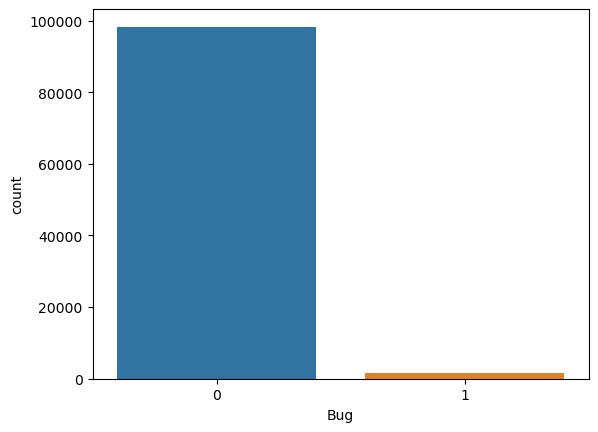

In [19]:
sns.countplot(dataset, x="Bug")

In [20]:
dataset.to_csv(OUTPUT_DIR + "dataset.csv", index=False)